# Generate

👏🏻 欢迎来到 Generate 的教程，在这里您将学习到：

1. 使用统一简洁的 API 替代不同平台杂乱的 SDK
2. 使用 `Generate` 生成文本，图像以及音频

## 做点小小的准备工作

### 安装

In [ ]:
# 第一步，安装 `generate-core` 😉
!pip install generate-core
# 顺便安装一下 rich 美化输出
!pip install rich 

`generate-core` 已经安装完成了，让我们看看能不能正确的引用 `generate` 包

In [5]:
try:
    import generate
    import rich
except ImportError as e:
    raise ValueError("没有执行 !pip install generate-core 和 rich 吗？") from e
else:
    print("一切都在计划之内，安装成功！")

一切都在计划之内，安装成功！


### 配置 OpenAI Key

在使用 `generate` 之前，需要先配置 OpenAI API Key，这样才能使用 OpenAI 的 API。 

`generate` 库使用 [Pydantic Settings](https://docs.pydantic.dev/latest/concepts/pydantic_settings/) 管理不同平台的配置，Pydantic Settings 会从 `.env` 文件，环境变量或者 **运行时** 获取相关配置。

不过，我们先不管这么多，就先通过环境变量来完成配置吧！

In [ ]:
import os

os.environ['OPENAI_API_KEY'] = 'sk-*****'

现在让我们测试一下配置是否生效

In [2]:
from generate.platforms import OpenAISettings
from pydantic import ValidationError

try:
    OpenAISettings()  # type: ignore
except ValidationError as e:
    raise ValueError("没有设置 OPENAI_API_KEY 环境变量吗？") from e
else:
    print("好的！热身完毕，一切准备就绪，下面让我们正式开始 🚀！")

好的！热身完毕，一切准备就绪，下面让我们正式开始 🚀！


## ChatCompletion 文本生成

在 `generate` 库中，无论是文本生成，图像生成，还是语音生成。他们遵循的都是相同的使用逻辑
1. 初始化生成模型
   - [可选] 选择模型型号
   - [可选] 设置默认的模型参数
2. 使用 `generate` 方法来调用模型
   - [必选] 设置 prompt, 对于 ChatCompletion 来说，prompt 一般就是文本
   - [可选] 设置此次调用的模型参数
3. 获取模型输出

### 基础使用
最简单的使用方式就是像下面这样，只控制 prompt，其他都使用默认值

In [6]:
from generate import OpenAIChat

model = OpenAIChat()
model_output = model.generate('你好，请介绍一下你自己')

rich.print(model_output)

ChatCompletionOutput(
    model_info=ModelInfo(task='chat_completion', type='openai', name='gpt-3.5-turbo-0613'),
    cost=0.0019390000000000002,
    extra={'usage': {'prompt_tokens': 19, 'completion_tokens': 129, 'total_tokens': 148}},
    messages=[
        AssistantMessage(
            content='你好！我是语言模型GPT-3，是由OpenAI开发的自然语言处理模型。我可
以进行文本生成、聊天对话、问题回答等任务。我是基于大量语料库进行训练的，因此能够提供丰富的语言表达和信息。我可以帮 
各种问题，提供信息和建议，帮助解决问题。如果你有任何需要，随时告诉我！',
            role='assistant',
            name=None,
            content_type='text'
        )
    ],
    finish_reason='stop'
)

我们可以看到模型输出了一个结构化的对象 `ChatCompletionOutput`，其中包括了一些有用的信息，比如：
- 模型信息，在 model_info 字段中，包含了任务种类，平台以及模型名称
- 生成消息，在 messages 字段中，包含了 gpt 模型生成的消息
- 计费信息，在 cost 字段中，包含了此次任务的花销，单位是元
- 结束原因，在 finish_reason 字段中，展示了此次任务完成的原因
- 额外信息，在 extra 字段中，包含了一些可能会有用的额外信息，比如此次任务使用了多少 token 等

`ChatCompletionOutput` 对象的基类是 [Pydantic BaseModel](https://docs.pydantic.dev/latest/concepts/models/)，因此我们可以通过访问属性的方式访问这些字段。

除此之外，`ChatCompletionOutput` 还提供了一些常用的计算属性，比如 `reply` 和 `last_message`。就像下面这样

In [8]:
cost = model_output.cost
reply = model_output.reply
last_message = model_output.last_message
rich.print(f'{cost=}')
rich.print(f'{reply=}')
rich.print(f'{last_message=}')

cost=0.0019390000000000002

reply='你好！我是语言模型GPT-3，是由OpenAI开发的自然语言处理模型。我可以进行文本生成、聊天对话、问
题回答等任务。我是基于大量语料库进行训练的，因此能够提供丰富的语言表达和信息。我可以帮助回答各种问题，提供信息和建 
助解决问题。如果你有任何需要，随时告诉我！'

last_message=AssistantMessage(content='你好！我是语言模型GPT-3，是由Ope
nAI开发的自然语言处理模型。我可以进行文本生成、聊天对话、问题回答等任务。我是基于大量语料库进行训练的，因此能够提供
富的语言表达和信息。我可以帮助回答各种问题，提供信息和建议，帮助解决问题。如果你有任何需要，随时告诉我！', role='as

### 设置模型及其参数

当然，我们也可以不使用默认的模型和参数，而是自定义他们。

模型的参数可以在模型初始化的时候设置，以作为模型的默认参数。也可以在调用 `generate` 方法的时候设置，以作为此次调用的参数。

- 初始化时的参数，必须显式声明，以 `OpenAIChat` 为例，它的参数为 `OpenAIChatParameters` 实例。
- 调用时的参数，无须显式声明，直接传入关键字参数即可，比如 `model.generate('你好', temperature=0.5)`
  
`generate` 包中的命名遵循固定的原则，任何模型参数的类名，都是模型名称 + Parameters
- OpenAIChat -> OpenAIChatParameters
- MinimaxChat -> MinimaxChatParameters

In [11]:
from generate import OpenAIChat, OpenAIChatParameters


model_parameters = OpenAIChatParameters(top_p=0.85) # 显式声明模型参数
model = OpenAIChat(model='gpt-4', parameters=model_parameters) # 使用 GPT-4 模型
model_output = model.generate('你好', temperature=0.9) # 调用时传入 temperature 参数
rich.print(model_output)

ChatCompletionOutput(
    model_info=ModelInfo(task='chat_completion', type='openai', name='gpt-4-0613'),
    cost=0.00903,
    extra={'usage': {'prompt_tokens': 9, 'completion_tokens': 17, 'total_tokens': 26}},
    messages=[
        AssistantMessage(
            content='你好！有什么可以帮助你的吗？',
            role='assistant',
            name=None,
            content_type='text'
        )
    ],
    finish_reason='stop'
)

### 流式输出

在 `generate` 方法前加上 stream，也就是 `stream_generate` ，就变成了流式输出！`stream_generate` 返回一个生产器，你可以通过 for 循环来迭代它。

In [13]:
stream_output = next(model.stream_generate('你好'))
rich.print(stream_output)

ChatCompletionStreamOutput(
    model_info=ModelInfo(task='chat_completion', type='openai', name='gpt-4'),
    cost=None,
    extra={},
    messages=[],
    finish_reason='',
    stream=Stream(delta='', control='start')
)

yield 的对象是 `ChatCompletionStreamOutput`，它只是在 `ChatCompletionOutput` 的基础上增加了一个 stream 字段，其中 delta 代表每次生产的小片段，control 标识了控制信息。

现在让我们完整的看一下流式输出的例子吧！

In [16]:
model = OpenAIChat()
finish_output = None
for output in model.stream_generate('介绍一下三体中的主要人物'):
    print(output.stream.delta, flush=True, end='')
    if output.stream.control == 'finish':
        finish_output = output


《三体》是刘慈欣创作的一部科幻小说系列，主要人物众多，以下是其中几位主要人物的简要介绍：

1. 王二：他是小说的主角之一，一个厂长。他在光荣的革命斗争中成长起来，并加入了红岸基地。他是一个理性、沉稳和坚定的人，对真相充满好奇，并不断寻求答案。

2. 邓老板：他是另一个主要角色，是一名企业家和地产商。他的财富和影响力使他成为故事中的重要人物。邓老板一直致力于改善人类社会，为人类的发展做出了重要贡献。

3. 程心：她是一位科学家，是故事的女主角之一。程心非常聪明和有天赋，她通过研究三体问题解决了一个长期困扰科学家的难题，并成为了三体计划的一部分。

4. 云天明：他是程心的丈夫，也是一个科学家。云天明是一个理想主义者，他相信科学和进步可以改变人类的未来。他成为了红岸基地的一员，并参与了与三体文明的联系。

5. 张叔平：他是一个退休的学者，成为了故事中一个重要的人物。张叔平对三体问题有着深入的研究，并尝试通过物理方法来解决这个难题。

除了以上的几位主要人物之外，还有许多其他角色在小说中扮演着重要的角色，如杨冬、吴京、吴德等。每一个主要角色都有各自的特点和经历，他们在故事中共同扮演着推动剧情发展和探索宇宙奥秘的角色。

In [17]:
rich.print(finish_output)

ChatCompletionStreamOutput(
    model_info=ModelInfo(task='chat_completion', type='openai', name='gpt-3.5-turbo'),
    cost=None,
    extra={},
    messages=[
        AssistantMessage(
            content='《三体》是刘慈欣创作的一部科幻小说系列，主要人物众多，以下是其中几位主要人物的简要介绍：\n\n1.
王二：他是小说的主角之一，一个厂长。他在光荣的革命斗争中成长起来，并加入了红岸基地。他是一个理性、沉稳和坚定的人， 
满好奇，并不断寻求答案。\n\n2. 
邓老板：他是另一个主要角色，是一名企业家和地产商。他的财富和影响力使他成为故事中的重要人物。邓老板一直致力于改善人 
为人类的发展做出了重要贡献。\n\n3. 
程心：她是一位科学家，是故事的女主角之一。程心非常聪明和有天赋，她通过研究三体问题解决了一个长期困扰科学家的难题， 
三体计划的一部分。\n\n4. 
云天明：他是程心的丈夫，也是一个科学家。云天明是一个理想主义者，他相信科学和进步可以改变人类的未来。他成为了红岸基 
，并参与了与三体文明的联系。\n\n5. 
张叔平：他是一个退休的学者，成为了故事中一个重要的人物。张叔平对三体问题有着深入的研究，并尝试通过物理方法来解决这 
难题。\n\n除了以上的几位主要人物之外，还有许多其他角色在小说中扮演着重要的角色，如杨冬、吴京、吴德等。每一个主要角
色都有各自的特点和经历，他们在故事中共同扮演着推动剧情发展和探索宇宙奥秘的角色。',
            role='assistant',
            name=None,
            content_type='text'
        )
    ],
    finish_reason='stop',
    stream=Stream(delta='', control='finish')
)

我们可以看到，control 为 finish 的 `ChatCompletionStreamOutput` 中依然包含了各种有用的信息！

### 多轮对话


上面介绍的例子都是单轮对话，而且也只涉及到文本，并不涉及到 FunctionCall，多模态对话等。

这部分的内容将在进阶使用中详细介绍，下面我们只给一个简单的例子。

In [18]:
output = model.generate(
    [
        {'role': 'user', 'content': '你好，GPT！'},
        {'role': 'assistant', 'content': '你好！有什么可以帮助你的吗？'},
        {'role': 'user', 'content': '重复我的第一句话'},
    ]
)
output.reply

'你好，GPT！'

### 输入及参数检查

`generate` 包会对你指定的模型参数进行提前检查

temperature 参数的取值范围是 0 到 1，如果你传入了一个不合法的值，那么 `generate` 会抛出一个异常，并告诉你 temperature 参数的取值范围

In [12]:
model.generate('你好', temperature=2)

ValidationError: 1 validation error for OpenAIChatParameters
temperature
  Input should be less than or equal to 1 [type=less_than_equal, input_value=2, input_type=int]
    For further information visit https://errors.pydantic.dev/2.5/v/less_than_equal

恭喜 🎉，你已经学会了 OpenAIChat 的基础使用。

掌握了 OpenAIChat 后，你也同样掌握了 `generate` 支持的所有聊天模型，他们的使用方式一模一样！

让我们看看，你的工具箱里面还有哪些武器吧~

In [23]:
from generate.chat_completion import ChatModels

model_names = [model.__name__ for model, _ in ChatModels]

print(f'以下的模型都可以通过和 OpenAIChat 一样的方式使用：')
print(model_names)

以下的模型都可以通过和 OpenAIChat 一样的方式使用：
['AzureChat', 'OpenAIChat', 'MinimaxProChat', 'MinimaxChat', 'ZhipuChat', 'ZhipuCharacterChat', 'WenxinChat', 'HunyuanChat', 'BaichuanChat', 'BailianChat']


### One More Thing


除了 `generate.chat_completion` 模型外，`generate` 还支持 `generate.image_generation` 和 `generate.text_to_speech` 模型。


而且，他们的使用方式也和 `generate.chat_completion` 一模一样！

In [24]:
from IPython.display import Audio, Image
from generate import OpenAISpeech

model = OpenAISpeech()
speech_output = model.generate('你好，世界！')
Audio(speech_output.audio)

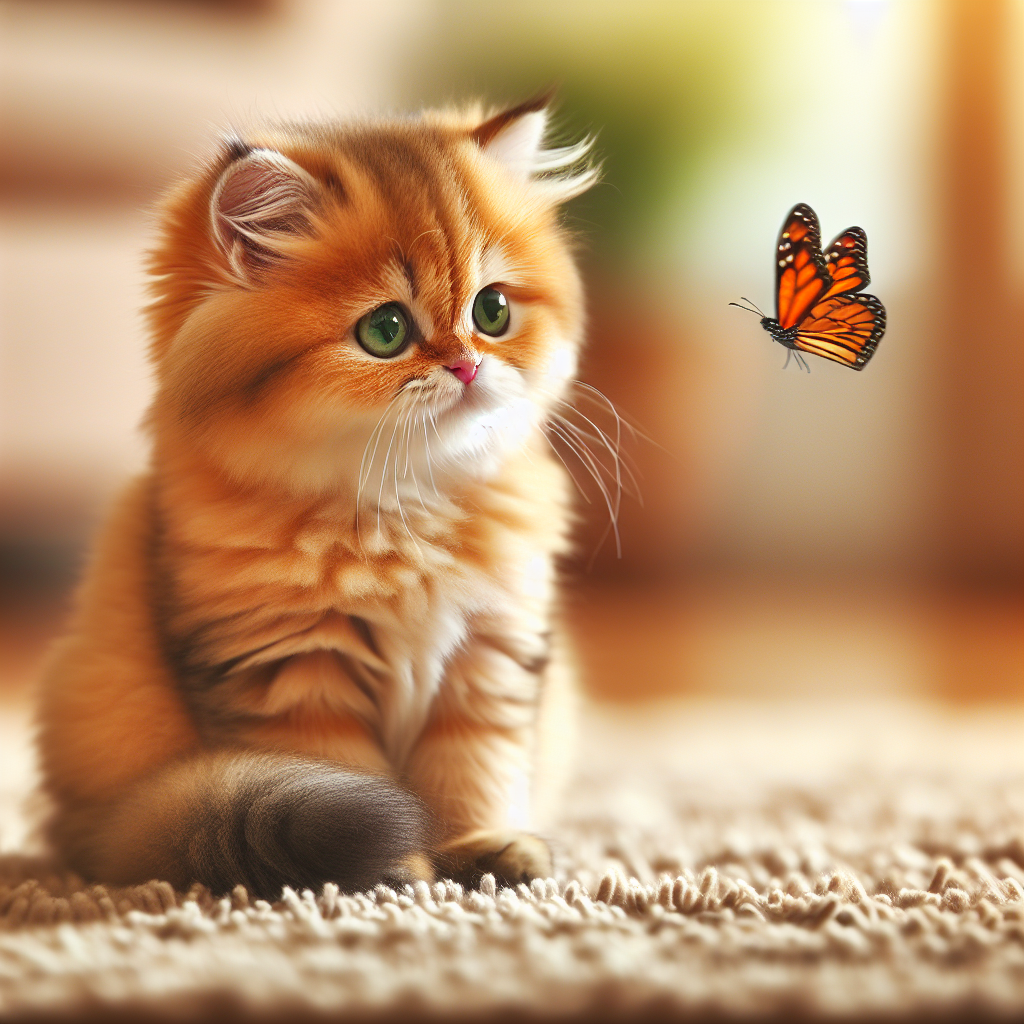

In [25]:
from generate import OpenAIImageGeneration

model = OpenAIImageGeneration(model='dall-e-2')
image_output = model.generate('一只可爱的猫')
Image(image_output.images[0].content)

基础使用教程已经结束啦！🌟 如果你想深入了解更多精彩内容，可以继续探索我们的进阶使用教程、丰富的应用示例，或者深入阅读 `Generate` 文档！

👩‍💻 对于以下议题感兴趣的朋友，请参考我们的[进阶使用教程](https://colab.research.google.com/github/wangyuxinwhy/generate/blob/main/examples/advanced_usage.ipynb)：
1. 异步调用 `model.async_generate` 和异步流式调用 `model.async_stream_generate`
2. 设定灵活的重试策略 
3. 探索 gpt-4 支持的多模态对话功能
4. 了解 FunctionCall 与 ToolCalls
5. 熟悉有状态的对话引擎 `generate.ChatEngine`
6. 学习适用于大规模请求的补全引擎 `generate.CompletionEngine`
7. 更多精彩内容等你发现...

🤖 同时，如果你对以下应用示例感兴趣，请不要错过我们的[应用示例](https://github.com/wangyuxinwhy/generate/tree/main/examples)：
1. 🚧 代码解释器
2. 🚧 多模态聊天机器人
3. 🚧 网络文学多角色配音体验

🔧 最后，如果你想了解如何配置其他大模型平台，或者全面系统地学习 `Generate`，请参考 [Generate 文档](https://wangyuxinwhy.github.io/generate/)

祝你探索愉快！🚀💡